Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!pip install tensorflow==2.17.0


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Test")


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

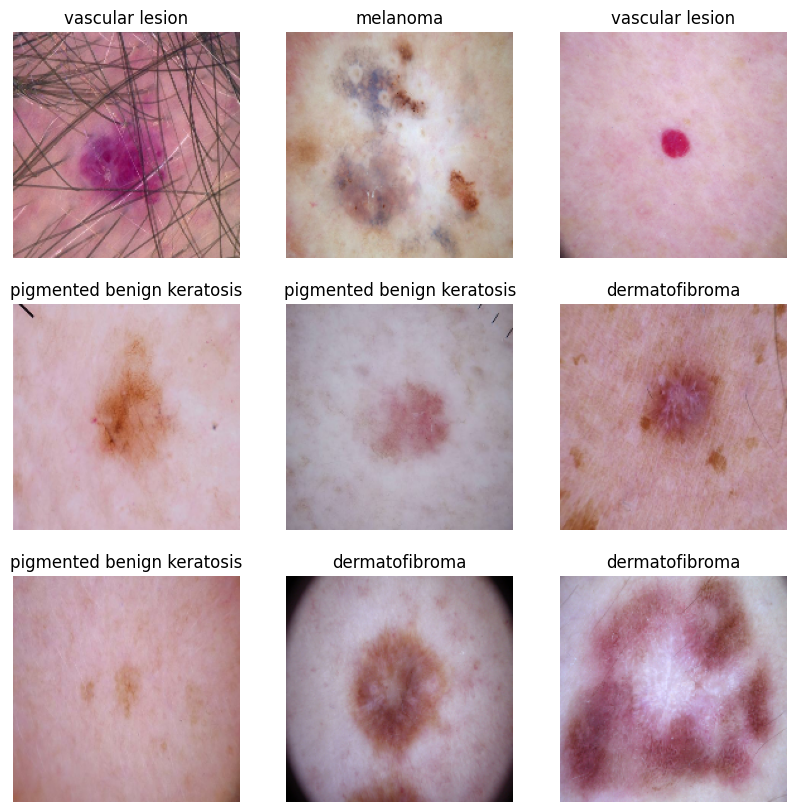

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

# Number of target labels are 9
target_labels = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(target_labels)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 14
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 1209s 2s/step - accuracy: 0.1831 - loss: 2.1364 - val_accuracy: 0.3180 - val_loss: 1.6798
Epoch 2/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.3917 - loss: 1.5570 - val_accuracy: 0.5174 - val_loss: 1.3201
Epoch 3/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.5490 - loss: 1.2267 - val_accuracy: 0.5871 - val_loss: 1.1441
Epoch 4/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6307 - loss: 1.0102 - val_accuracy: 0.6286 - val_loss: 1.0862
Epoch 5/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.6943 - loss: 0.8821 - val_accuracy: 0.6494 - val_loss: 1.0651
Epoch 6/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.7589 - loss: 0.6865 - val_accuracy: 0.7220 - val_loss: 0.8398
Epoch 7/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.8119 - loss: 0.5303 - val_accuracy: 0.7376 - val_loss: 0.8385
Epoch 8/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8582 - loss: 0.4095 - val_acc

### Visualizing training results

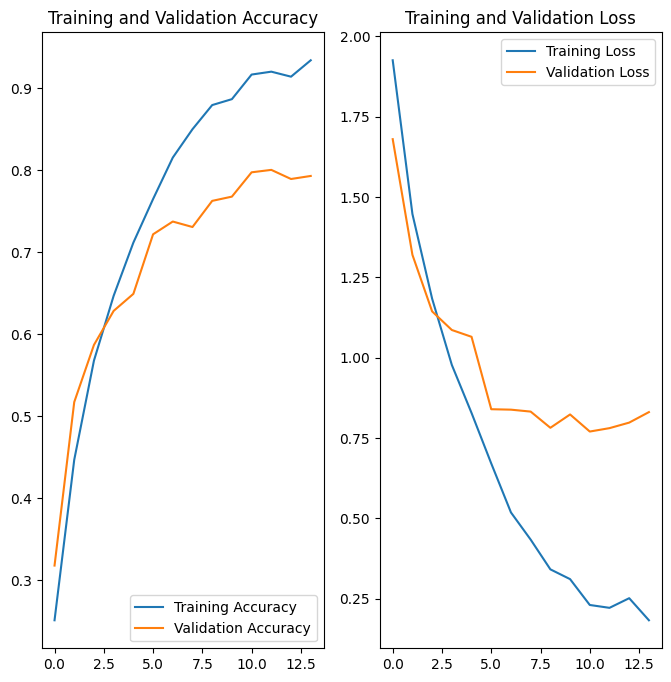

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Observations:**


*  The model's training accuracy shows a steady increase of upto 90%, while validation accuracy remains consistently around 55%.

*  A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability and the model is overfitting on the training data.

* These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.



In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

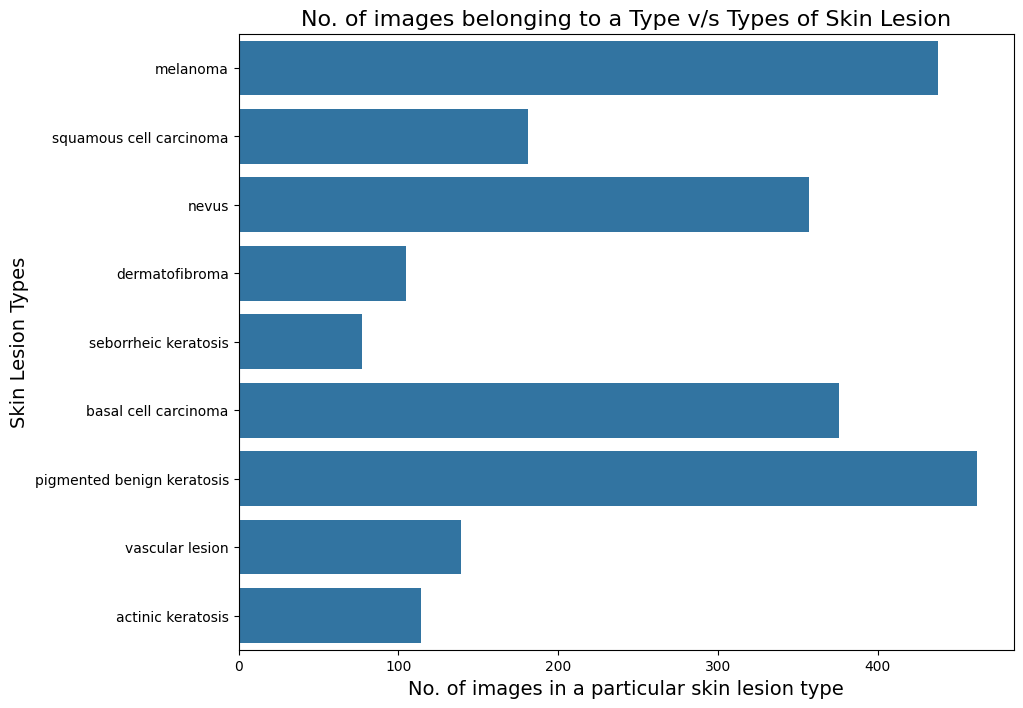

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()


### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.1864 - loss: 2.1752 - val_accuracy: 0.4047 - val_loss: 1.6170
Epoch 2/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.3668 - loss: 1.6333 - val_accuracy: 0.4603 - val_loss: 1.4696
Epoch 3/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.4424 - loss: 1.4466 - val_accuracy: 0.4804 - val_loss: 1.3994
Epoch 4/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.4686 - loss: 1.3933 - val_accuracy: 0.5330 - val_loss: 1.2513
Epoch 5/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.5122 - loss: 1.2881 - val_accuracy: 0.5204 - val_loss: 1.2752
Epoch 6/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.5370 - loss: 1.1862 - val_accuracy: 0.5441 - val_loss: 1.2122
Epoch 7/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.5333 - loss: 1.2050 - val_accuracy: 0.5419 - val_loss: 1.1912
Epoch 8/14
169/169 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5638 - loss: 1.1621 - val_accu

### Visualizing the results

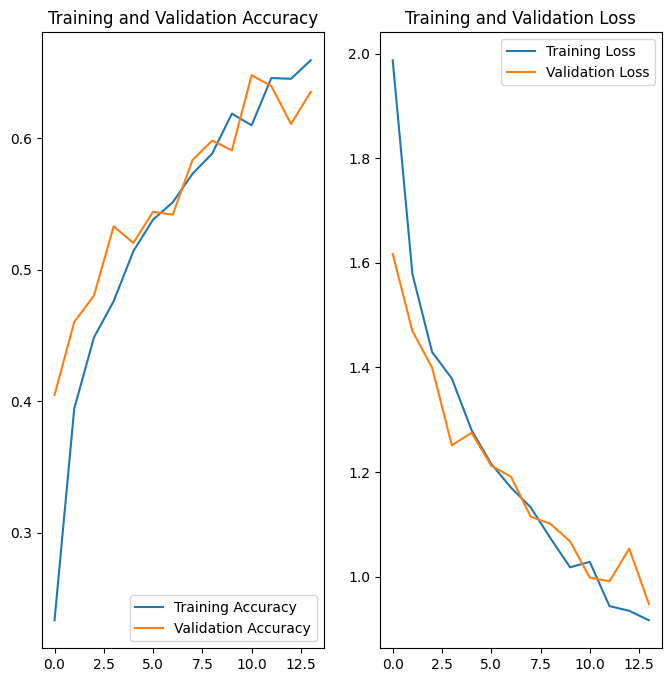

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

****Observations:****

* By leveraging augmented data, overfitting has been effectively addressed.

* The training and validation accuracy of the aforementioned model fall within a similar range.

* Both the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [19]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2249


In [20]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/ISIC_0000143.jpg', 'melanoma'), ('/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/ISIC_0000141.jpg', 'melanoma'), ('/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/ISIC_0000139.jpg', 'melanoma'), ('/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/ISIC_0000144.jpg', 'melanoma'), ('/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/ISIC_0000142.jpg', 'melanoma')]


In [21]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/ML 66/Skin cancer ISI...,melanoma
1,/content/gdrive/My Drive/ML 66/Skin cancer ISI...,melanoma
2,/content/gdrive/My Drive/ML 66/Skin cancer ISI...,melanoma
3,/content/gdrive/My Drive/ML 66/Skin cancer ISI...,melanoma
4,/content/gdrive/My Drive/ML 66/Skin cancer ISI...,melanoma


In [22]:
 ## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,105
seborrheic keratosis,77


#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### Rectify the class imbalance
# **Observations:**

A clear class imbalance is evident within the training data.

* The class "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately 3.44%.

* "Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 20.63% and 19.56% of the data, respectively.

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x797383EB2050>: 100%|██████████| 500/500 [00:05<00:00, 89.74 Samples/s] 


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x797380409D50>: 100%|██████████| 500/500 [00:05<00:00, 93.85 Samples/s] 


Initialised with 105 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7973844C2410>: 100%|██████████| 500/500 [00:05<00:00, 94.62 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x797383E2B7D0>: 100%|██████████| 500/500 [00:25<00:00, 19.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x797384053010>: 100%|██████████| 500/500 [00:26<00:00, 18.61 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x797384169F50>: 100%|██████████| 500/500 [00:05<00:00, 88.93 Samples/s] 


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x797383EB0490>: 100%|██████████| 500/500 [00:12<00:00, 40.36 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7973804998D0>: 100%|██████████| 500/500 [00:05<00:00, 86.64 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x797383E70390>: 100%|██████████| 500/500 [00:05<00:00, 83.42 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0010410.jpg_79198048-4654-4cfb-b1d9-fce77f3db046.jpg',
 '/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0000513.jpg_edfaa135-6a7c-4388-8f07-cb501675e0a3.jpg',
 '/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0010407.jpg_63469092-f709-419e-94b8-3c917979726e.jpg',
 '/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0010714.jpg_e1edc890-7578-4470-b6ff-b99ffe0c5ec1.jpg',
 '/content/gdrive/My Drive/ML 66/Skin cancer ISIC The International Skin Imaging Collaboration 2/Train/melanoma/output/melanoma_original_ISIC_0010866.jpg_287be3cd-d385-40fe-9de7-618214823032.jpg']

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = lesions_df._append(df2)
new_df.shape

(6749, 2)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,605
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


####  Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


####Create your model (make sure to include normalization)

In [ ]:


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
#Compile the Model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

####  Train your model

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3996 - loss: 1.5730
Epoch 1: val_accuracy improved from -inf to 0.45960, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.3997 - loss: 1.5727 - val_accuracy: 0.4596 - val_loss: 1.4182
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4642 - loss: 1.4098
Epoch 2: val_accuracy improved from 0.45960 to 0.51964, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.4643 - loss: 1.4096 - val_accuracy: 0.5196 - val_loss: 1.2867
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5283 - loss: 1.2629
Epoch 3: val_accuracy improved from 0.51964 to 0.54930, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.5283 - loss: 1.2629 - val_accuracy: 0.5493 - val_loss: 1.2304
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5774 - loss: 1.1205
Epoch 4: val_accuracy improved from 0.54930 to 0.61972, saving model

#### Visualize the model results

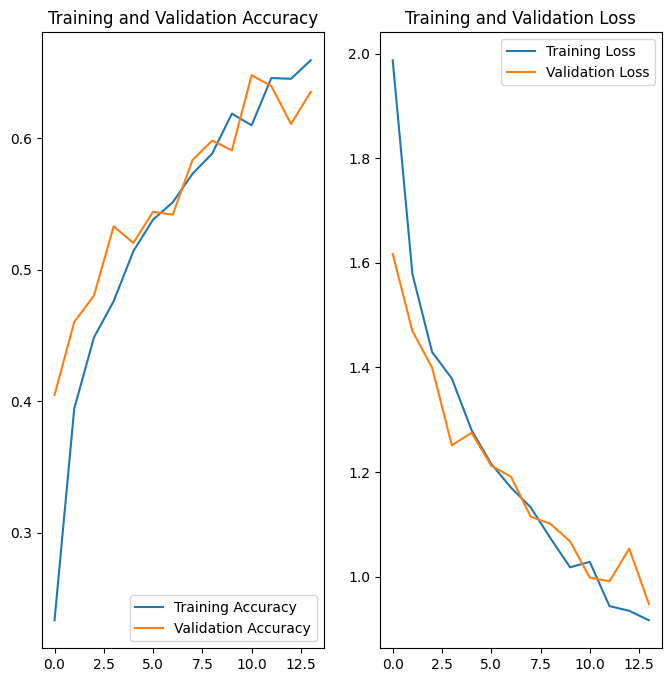

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

* The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

* Following 20 epochs, the final model attains an accuracy of 88% on the training set and approximately 84% on the validation set.

The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.